In [1]:
from pylab import *
import matplotlib as mpl
import seaborn as sns
import calc11
import numpy as np
%matplotlib inline


In [42]:
fc = 1.32 # center frequency GHz
bw = 0.336 # bandwidth GHz
Nd = 512 # number of DM trials
Nt = 512 # time block size
Nb = 4 # bytes per complex sample. 4 = fp16 complex
Tint = 1e-3 # integration time - seconds
Nchan=336
Npol = 2 # input number of polarisations

f1 = fc - bw/2.
f2 = fc + bw/2.
nchan = 336
lam1 = 3e8/f1/1e9
lam2 = 3e8/f2/1e9
print lam1, lam2
Npix = 192
ignore_ant = ['ak30','ak31','ak32','ak33','ak34','ak35','ak36']


0.260416666667 0.201612903226


In [43]:
cfile = calc11.ResultsFile('SB6357.im')

In [44]:
mjd = cfile.scans[0].first_mjd
p = cfile.scans[0].eval_src0_poly(mjd)
telnames = [t for t in cfile.telnames if t not in ignore_ant]
print 'Got', len(telnames), 'antennas'

Got 22 antennas


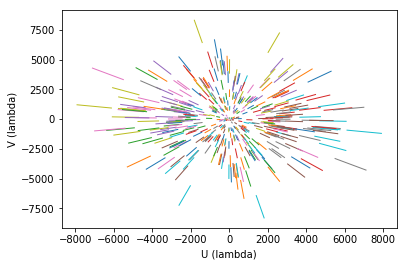

In [45]:
figure()
all_rlam = []
uvw = []
for ia1, a1 in enumerate(telnames):
    for ia2, a2 in enumerate(telnames[ia1+1:]):
        #u = [val[a1]['U (m)'] - val[a2]['U (m)'] for val in values]
        #v = [val[a1]['V (m)'] - val[a2]['V (m)'] for val in values]
        #w = [val[a1]['W (m)'] - val[a2]['W (m)'] for val in values]
        u = p[a1]['U (m)'] - p[a2]['U (m)']
        v = p[a1]['V (m)'] - p[a2]['V (m)']
        w = p[a1]['W (m)'] - p[a2]['W (m)']
        uvw.append((u,v,w))
        #print a1, a2, u, v, w
        ulam1, vlam1, wlam1 = u/lam1, v/lam1, w/lam1
        ulam2, vlam2, wlam2 = u/lam2, v/lam2, w/lam2
        r = np.sqrt(u*u + v*v)
        rlam1 = r/lam1
        rlam2 = r/lam2
        all_rlam.append((rlam1 - rlam2))
        plot([ulam1, ulam2], [vlam1, vlam2])
        plot([-ulam1, -ulam2], [-vlam1, -vlam2])

        
xlabel('U (lambda)')
ylabel('V (lambda)')
uvw = np.array(uvw)
uvwlam1 = uvw/lam1
uvwlam2 = uvw/lam2
        

In [65]:
assert(lam2 < lam1)

urange = uvwlam2[:, 0].max() - uvwlam2[:, 0].min()
vrange = uvwlam2[:, 1].max() - uvwlam2[:, 1].min()
lres = np.degrees(1.0/urange)*3600.
mres = np.degrees(1.0/vrange)*3600.
ucell = urange/float(Npix)
vcell = vrange/float(Npix)
lsize = np.degrees(1./ucell)
msize = np.degrees(1./vcell)
cellsize = min(ucell, vcell)

print 'UV range={:0.1f}x{:0.1f} lambda = {:0.1f}x{:0.1f} arcsec FoV: {:0.2f}x{:0.2f} deg'.format(urange, vrange, lres, mres,lsize, msize)

UV range=13192.1x13923.4 lambda = 15.6x14.8 arcsec FoV: 0.83x0.79 deg


In [55]:
# loop through baselines, working out the rounded uv cells where each one starts and stops
uvcell_start = np.round(uvwlam1/cellsize)
uvcell_end = np.round(uvwlam2/cellsize)

# radius in uv at which the track starts
rstart = np.sqrt(uvcell_start[:, 0]**2 + uvcell_start[:, 1]**2)
# radius at which it ends
rend = np.sqrt(uvcell_end[:, 0]**2 + uvcell_end[:, 1]**2)
rdist = rend - rstart 
rd30 = rdist.mean()*(30*29/2.) # guessing at the total non-zero uv plane for 30 antennas
print 'Radial distances', len(rdist), 'baselines', rdist.max(), rdist.min(), rdist.mean(), rdist.sum(), 'max/min/mean/sum'
print 'Guessing at ', rd30, 'Nonzero UVcells for 30 antennas'

Radial distances 231 baselines 27.657757903897107 0.0 10.361751539821034 2393.564605698659 max/min/mean/sum
Guessing at  4507.3619198221495 Nonzero UVcells for 30 antennas


Text(0,0.5,'Number of baselines')

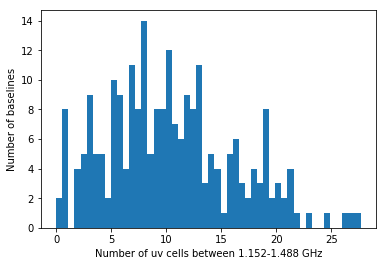

In [48]:
hist(rdist, bins=50)
xlabel('Number of uv cells between {:0.3f}-{:0.3f} GHz'.format(f1,f2))
ylabel('Number of baselines')

In [26]:
print 'Required memory', rdist.sum()*Nd*Nt*4/1e9, 'GBytes or', rdist.mean()*(30*29/2)*Nd*Nt*4/1e9, 'GBytes for 30 antennas'

Required memory 2.5098343999850767 GBytes or 4.72631153243943 GBytes for 30 antennas


In [49]:
print '30 antenna UV cells', rd30, 'Per baseline mean', rdist.mean()
print 'input rate', 30*29/2*Nchan*1*Nb*Npol*8/Tint/1e9, 'Gbits/sec'

30 antenna UV cells 4507.3619198221495 Per baseline mean 10.361751539821034
input rate 9.35424 Gbits/sec


In [64]:
Nd0 = 16 # Number of DM trials in first iteration
Niter = np.ceil(np.log2(Nchan))
Nbl = 30*29/2
# ah, but, you only do it for the number of baselines - because to unite 2 freqs, you don't need to read in the whole UV line
# Or do you?
print "FMDT Memory bandwidth if you only move around 1 point per iteration", Nd0*Nchan*Niter/Tint*Nb/1e9*Nbl, 'GByte/sec'
print "FMDT Memory bandwidth if you move the whole grid around per iteration", Nd0*Nchan*Niter/Tint*Nb/1e9*rd30, 'GByte/sec'

FMDT Memory bandwidth if you only move around 1 point per iteration 84.18816000000001 GByte/sec
FMDT Memory bandwidth if you move the whole grid around per iteration 872.3367965146996 GByte/sec


 yeah, but you can just do 1 point - because when you've finished with one point, you write it to the 
 full output and never touch it again. Err, but where does it actually go in the end. Maybe you really do need to copy the whole thing. Bleah. Yeah OK - hut the size is growing (ie. it's length 1 a the beginning, and length Nmax at the end, so there's at least a factor of 2 impreovment over teh whole grid calculation).Yeah, but can you do that? how do you organise the data?
 
 
 Actually no - the trick here is to FDMT inside a cell, then just pick up data across the cells - no log2 required thankyou sir.